# Define similarity measures

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

In [3]:
def dot_similarity(vector1, vector2):
    return np.sum(np.multiply(np.array(vector1), np.array(vector2)))

def cosine_similarity(vector1, vector2):
    return dot_similarity(vector1, vector2) / np.sqrt(np.sum(vector1)**2 * np.sum(vector2)**2)

# Data tokenization

In [4]:
def get_boolean_representation(corpus, stop_words_list='english'):
    vectorizer = CountVectorizer(binary=True, stop_words=stop_words_list)
    X = vectorizer.fit_transform(corpus)
    return X.toarray(), vectorizer.get_feature_names_out()

def get_tf_representation(corpus, stop_words_list='english'):
    vectorizer = CountVectorizer(binary=False, stop_words=stop_words_list)
    X = vectorizer.fit_transform(corpus)
    vectorizer.get_feature_names_out()
    return X.toarray()

def get_tf_idf_representation(corpus, stop_words_list='english'):
    vectorizer = TfidfVectorizer(stop_words=stop_words_list)
    X = vectorizer.fit_transform(corpus)
    vectorizer.get_feature_names_out()
    return X.toarray()

# Experiments for k-means

We realise two k-means (one for each labels) to try to group the sentences together, in order sentences that are related will be in the same cluster for example for label 0 : if some sentences are about fishing and others about architecture we want them to be separated to create more specific centroids.

In [5]:
index_train = np.load('../data/array_idx_train.npy')
index_val = np.load('../data/array_idx_val.npy')

df = pd.read_csv('../data/DataFrame_train_full_preprocessing.csv')

representation_boolean, vocabulary = get_boolean_representation(df['text'].apply(lambda x : x.lower()))
representation_tf = get_tf_representation(df['text'].apply(lambda x : x.lower()))
representation_tf_idf = get_tf_idf_representation(df['text'].apply(lambda x : x.lower()))

y_train = df.loc[index_train, 'label']
y_val = df.loc[index_val, 'label']

del df

x_train_boolean = representation_boolean[index_train]
x_val_boolean = representation_boolean[index_val]

x_train_tf = representation_tf[index_train]
x_val_tf = representation_tf[index_val]

x_train_tf_idf = representation_tf_idf[index_train]
x_val_tf_idf = representation_tf_idf[index_val]

In [6]:
class k_means_centroids_model:
    centroids = None
    centroids_labels = None
    n_cluster_1=1
    n_cluster_0=1
    k_means_labels = None

    def get_k_means_labels(self):
        if self.k_means_labels is None:
            print('Error : class must be fitted before')
            exit(-1)
        else:
            return self.k_means_labels[0], self.k_means_labels[1]


    def get_centroids(self):
        if self.centroids is None:
            print('Error : class must be fitted before')
            exit(-1)
        else:
            return self.centroids[0], self.centroids[1]


    def get_centroids_labels(self):
        if self.centroids_labels is None:
            print('Error : class must be fitted before')
            exit(-1)
        else:
            return self.centroids_labels


    def fit(self, data, labels,  n_cluster_1=1, n_cluster_0=1):
        self.n_cluster_1 = n_cluster_1
        self.n_cluster_0 = n_cluster_0
        index_label_0 = np.argwhere(np.array(labels) == 0).reshape(-1)
        index_label_1 = np.argwhere(np.array(labels) == 1).reshape(-1)

        # k-means for label 1
        kmeans_1 = KMeans(n_clusters=n_cluster_1, random_state=0).fit(data[index_label_1])

        # k-means for label 0
        kmeans_0 = KMeans(n_clusters=n_cluster_0, random_state=0).fit(data[index_label_0])

        self.k_means_labels = kmeans_1.labels_, kmeans_0.labels_
        self.centroids = kmeans_1.cluster_centers_, kmeans_0.cluster_centers_
        self.centroids_labels = np.append((np.zeros(n_cluster_1)+1).astype(int), [(np.zeros(n_cluster_0)).astype(int)])


    def predict(self, data, similarity='cosine'):
        if self.centroids is None or self.centroids_labels is None :
            print('Error : class must be fitted before prediction')
            exit(-1)
        if similarity == 'dot':
            max_in_label_0 = [np.max([dot_similarity(entry, self.centroids[1][j]) for j in range(self.n_cluster_0)]) for entry in data]
            max_in_label_1 = [np.max([dot_similarity(entry, self.centroids[0][j]) for j in range(self.n_cluster_1)]) for entry in data]
            return [1 if max_in_label_1[i] > max_in_label_0[i] else 0 for i in range(len(max_in_label_1))]
        else:
            max_in_label_0 = [np.max([cosine_similarity(entry, self.centroids[1][j]) for j in range(self.n_cluster_0)]) for entry in data]
            max_in_label_1 = [np.max([cosine_similarity(entry, self.centroids[0][j]) for j in range(self.n_cluster_1)]) for entry in data]
            return [1 if max_in_label_1[i] > max_in_label_0[i] else 0 for i in range(len(max_in_label_1))]

In [8]:
results_boolean = pd.DataFrame(columns=['n_cluster_lab_1', 'n_cluster_lab_2', 'acc', 'aucroc'])
results_tf = pd.DataFrame(columns=['n_cluster_lab_1', 'n_cluster_lab_2', 'acc', 'aucroc'])
results_tf_idf = pd.DataFrame(columns=['n_cluster_lab_1', 'n_cluster_lab_2', 'acc', 'aucroc'])

for n_1 in range(1, 4):
    for n_2 in range(1, 8):

        print(n_1, n_2)

        model = k_means_centroids_model()
        model.fit(x_train_boolean, y_train, n_cluster_1=n_1, n_cluster_0=n_2)
        y_predict = model.predict(x_val_boolean, similarity='cosine_similarity')
        results_boolean = results_boolean.append(pd.DataFrame({'n_cluster_lab_1':[n_1],'n_cluster_lab_2':[n_2],'acc':[accuracy_score(y_val, y_predict)],'aucroc':[roc_auc_score(y_val, y_predict)]}))

        model = k_means_centroids_model()
        model.fit(x_train_tf, y_train, n_cluster_1=n_1, n_cluster_0=n_2)
        y_predict = model.predict(x_val_tf, similarity='cosine_similarity')
        results_tf = results_tf.append(pd.DataFrame({'n_cluster_lab_1':[n_1],'n_cluster_lab_2':[n_2],'acc':[accuracy_score(y_val, y_predict)],'aucroc':[roc_auc_score(y_val, y_predict)]}))

        model = k_means_centroids_model()
        model.fit(x_train_tf_idf, y_train, n_cluster_1=n_1, n_cluster_0=n_2)
        y_predict = model.predict(x_val_tf_idf, similarity='cosine_similarity')
        results_tf_idf = results_tf_idf.append(pd.DataFrame({'n_cluster_lab_1':[n_1],'n_cluster_lab_2':[n_2],'acc':[accuracy_score(y_val, y_predict)],'aucroc':[roc_auc_score(y_val, y_predict)]}))

        print(results_boolean)

results_boolean.to_csv('k_means_boolean_repr_cosine_rapport.csv')
results_tf.to_csv('k_means_tf_repr_cosine_rapport.csv')
results_tf_idf.to_csv('k_means_tf_idf_repr_cosine_rapport.csv')

  n_cluster_lab_1 n_cluster_lab_2     acc    aucroc
0               1               1  0.6625  0.781419
0               1               2  0.7975  0.862838
1 3
  n_cluster_lab_1 n_cluster_lab_2     acc    aucroc
0               1               1  0.6625  0.781419
0               1               2  0.7975  0.862838
0               1               3  0.7850  0.854902
1 4
  n_cluster_lab_1 n_cluster_lab_2     acc    aucroc
0               1               1  0.6625  0.781419
0               1               2  0.7975  0.862838
0               1               3  0.7850  0.854902
0               1               4  0.8800  0.906629
1 5
  n_cluster_lab_1 n_cluster_lab_2     acc    aucroc
0               1               1  0.6625  0.781419
0               1               2  0.7975  0.862838
0               1               3  0.7850  0.854902
0               1               4  0.8800  0.906629
0               1               5  0.8675  0.898693
1 6
  n_cluster_lab_1 n_cluster_lab_2     acc    auc

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
print("Results for boolean representation")
print(results_boolean)
print('\n')
print("Results for tf representation")
print(results_tf)
print('\n')
print("Results for tf-idf representation")
print(results_tf_idf)
print('\n')

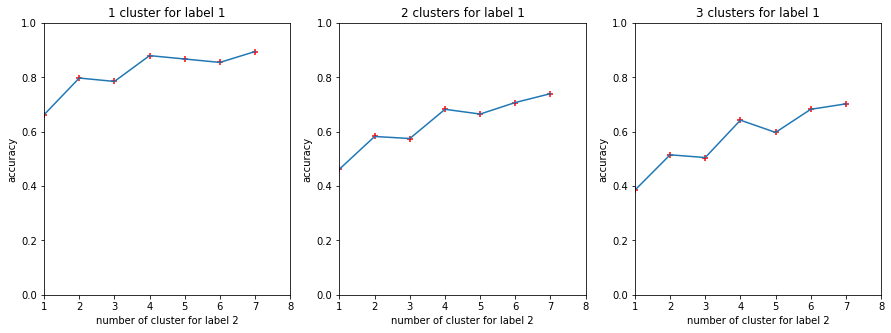

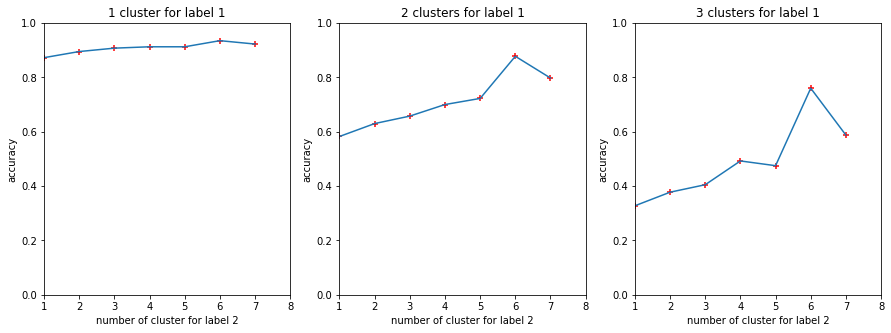

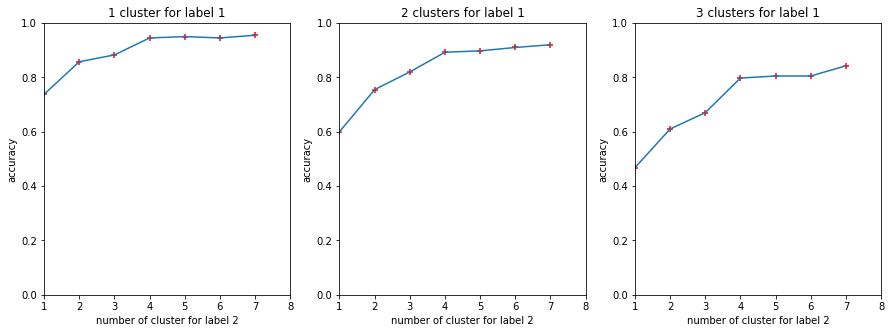

In [8]:
import matplotlib.pyplot as plt

z = 0
filename = ['accuracy_boolean_repr_rapport.png', 'accuracy_tf_repr_rapport.png', 'accuracy_tf_idf_repr_rapport.png']
for df in [results_boolean, results_tf, results_tf_idf]:
    fig = plt.figure(figsize=(15,5))
    fig.title =  'Accuracy depending on the number of clusters'

    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2, sharey=ax1)
    ax3 = fig.add_subplot(1, 3, 3, sharey=ax1)

    x, y = np.array(df[df['n_cluster_lab_1'] == 1]['n_cluster_lab_2'].tolist()), np.array(df[df['n_cluster_lab_1'] == 1]['acc'].tolist())
    ax1.plot(x, y)
    ax1.scatter(x, y, c='red', marker='+')
    ax1.set_title("1 cluster for label 1")
    ax1.set_xlim([1,11])
    ax1.set_ylim([0,1])
    ax1.set_xlabel("number of cluster for label 2")
    ax1.set_ylabel("accuracy")

    x, y = np.array(df[df['n_cluster_lab_1'] == 2]['n_cluster_lab_2'].tolist()), np.array(df[df['n_cluster_lab_1'] == 2]['acc'].tolist())
    ax2.plot(x, y)
    ax2.scatter(x, y, c='red', marker='+')
    ax2.set_title("2 clusters for label 1")
    ax2.set_xlim([1,11])
    ax2.set_ylim([0,1])
    ax2.set_xlabel("number of cluster for label 2")
    ax2.set_ylabel("accuracy")

    x, y = np.array(df[df['n_cluster_lab_1'] == 3]['n_cluster_lab_2'].tolist()), np.array(df[df['n_cluster_lab_1'] == 3]['acc'].tolist())
    ax3.plot(x, y)
    ax3.scatter(x, y, c='red', marker='+')
    ax3.set_title("3 clusters for label 1")
    ax3.set_xlim([1,11])
    ax3.set_ylim([0,1])
    ax3.set_xlabel("number of cluster for label 2")
    ax3.set_ylabel("accuracy")

    plt.show()
    fig.savefig(fname=filename[z])
    z += 1

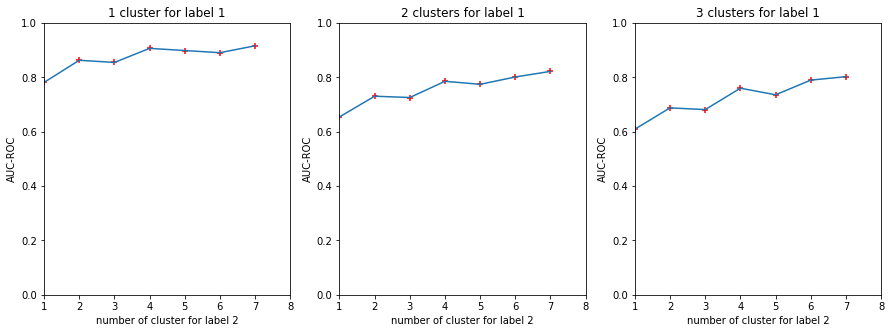

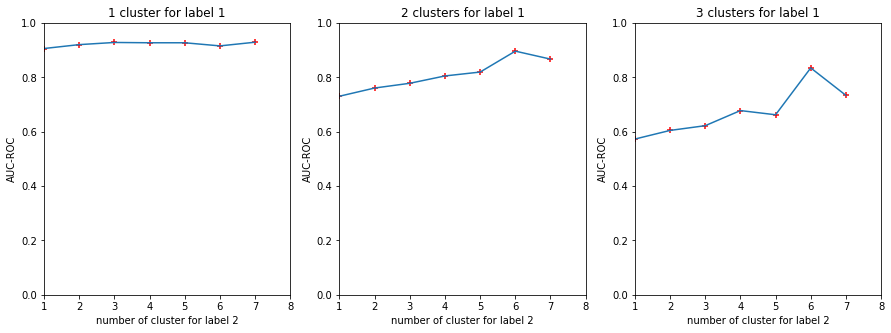

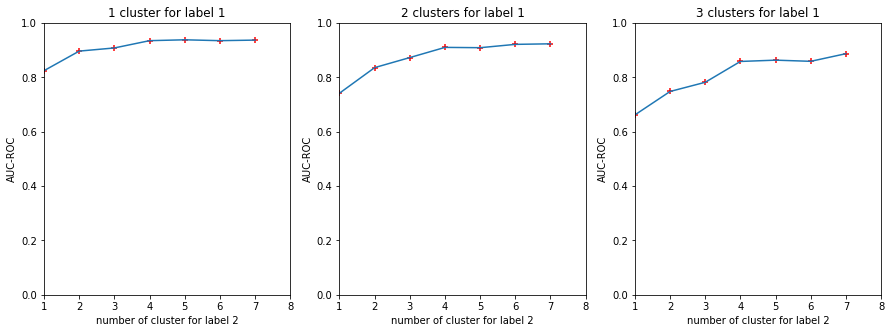

In [9]:
import matplotlib.pyplot as plt

z = 0
filename = ['auc_roc_boolean_repr_rapport.png', 'auc_roc_tf_repr_rapport.png', 'auc_roc_tf_idf_repr_rapport.png']
for df in [results_boolean, results_tf, results_tf_idf]:
    fig = plt.figure(figsize=(15,5))
    plt.title =  'AUC-ROC depending on the number of clusters'

    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2, sharey=ax1)
    ax3 = fig.add_subplot(1, 3, 3, sharey=ax1)

    x, y = np.array(df[df['n_cluster_lab_1'] == 1]['n_cluster_lab_2'].tolist()), np.array(df[df['n_cluster_lab_1'] == 1]['aucroc'].tolist())
    ax1.plot(x, y)
    ax1.scatter(x, y, c='red', marker='+')
    ax1.set_title("1 cluster for label 1")
    ax1.set_xlim([1,11])
    ax1.set_ylim([0,1])
    ax1.set_xlabel("number of cluster for label 2")
    ax1.set_ylabel("AUC-ROC")

    x, y = np.array(df[df['n_cluster_lab_1'] == 2]['n_cluster_lab_2'].tolist()), np.array(df[df['n_cluster_lab_1'] == 2]['aucroc'].tolist())
    ax2.plot(x, y)
    ax2.scatter(x, y, c='red', marker='+')
    ax2.set_title("2 clusters for label 1")
    ax2.set_xlim([1,11])
    ax2.set_ylim([0,1])
    ax2.set_xlabel("number of cluster for label 2")
    ax2.set_ylabel("AUC-ROC")

    x, y = np.array(df[df['n_cluster_lab_1'] == 3]['n_cluster_lab_2'].tolist()), np.array(df[df['n_cluster_lab_1'] == 3]['aucroc'].tolist())
    ax3.plot(x, y)
    ax3.scatter(x, y, c='red', marker='+')
    ax3.set_title("3 clusters for label 1")
    ax3.set_xlim([1,11])
    ax3.set_ylim([0,1])
    ax3.set_xlabel("number of cluster for label 2")
    ax3.set_ylabel("AUC-ROC")

    plt.show()
    fig.savefig(fname=filename[z])
    z += 1

# Word Frequency

In [10]:
mod = k_means_centroids_model()
mod.fit(x_train_tf_idf, y_train, n_cluster_1=1, n_cluster_0=7)
clusters = mod.get_k_means_labels()

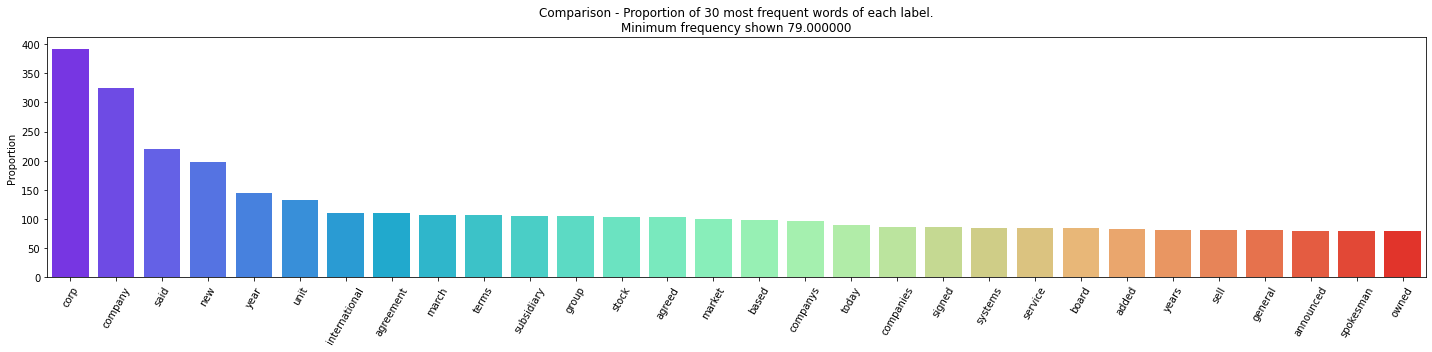

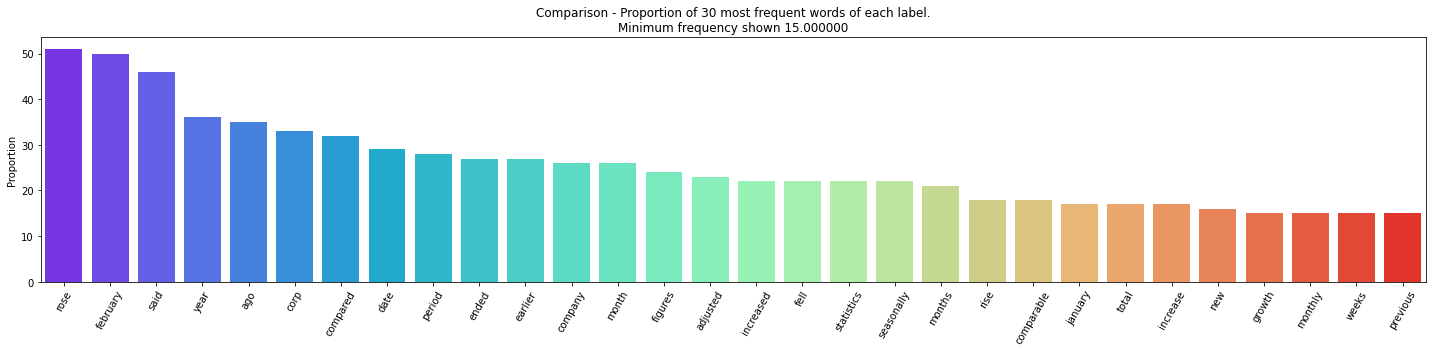

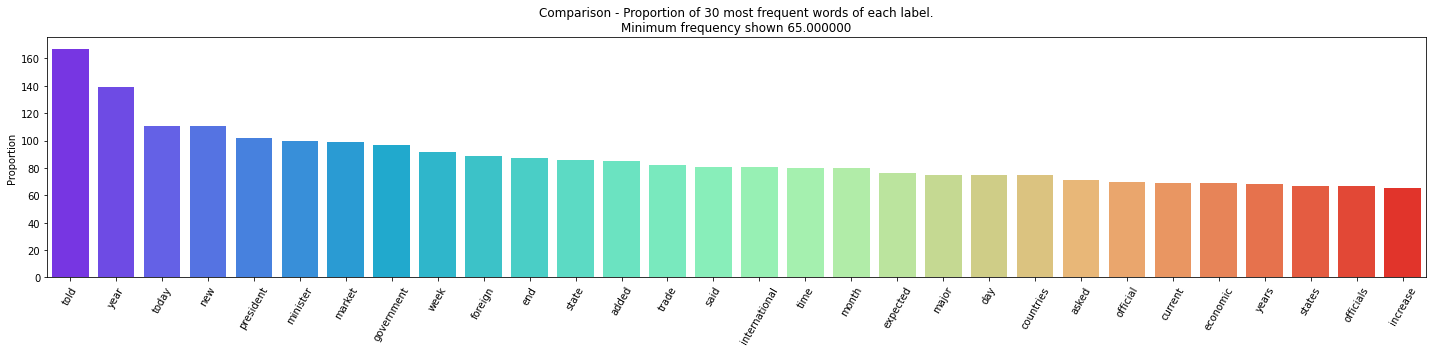

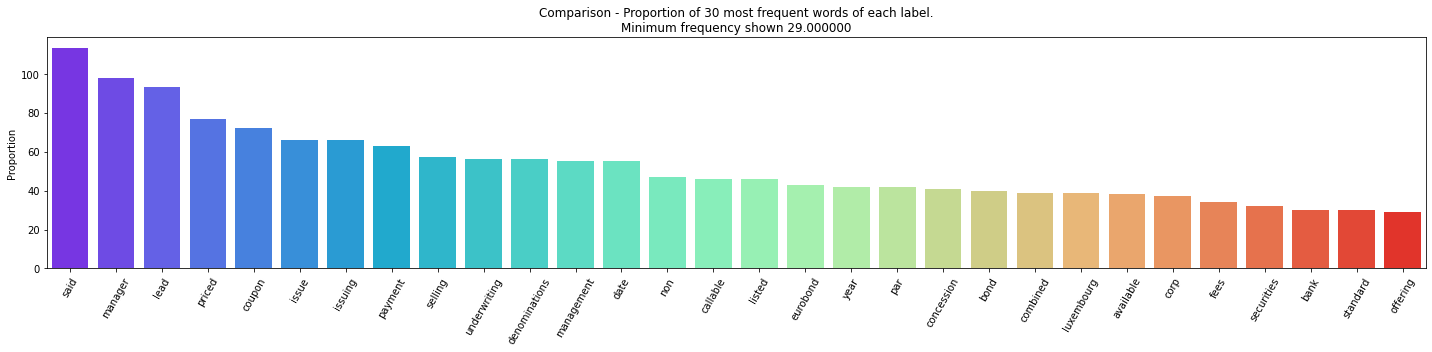

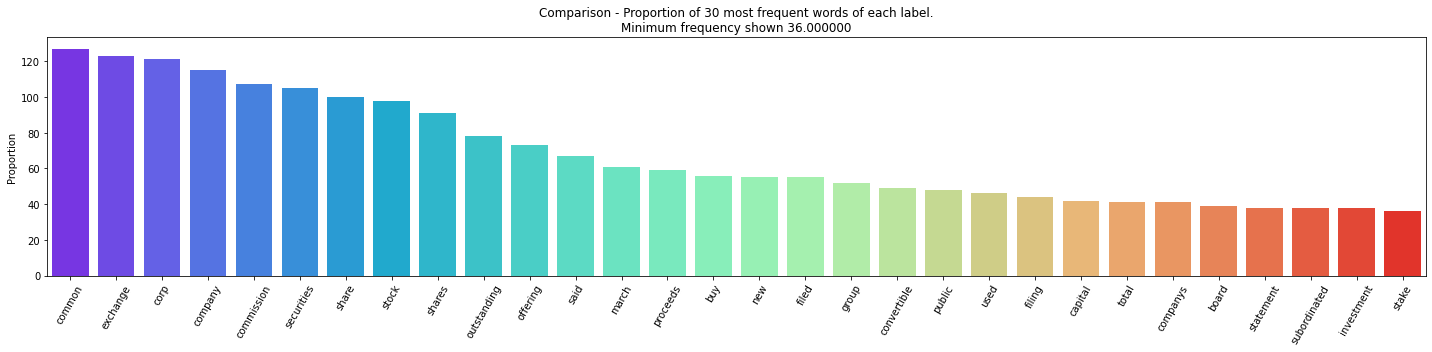

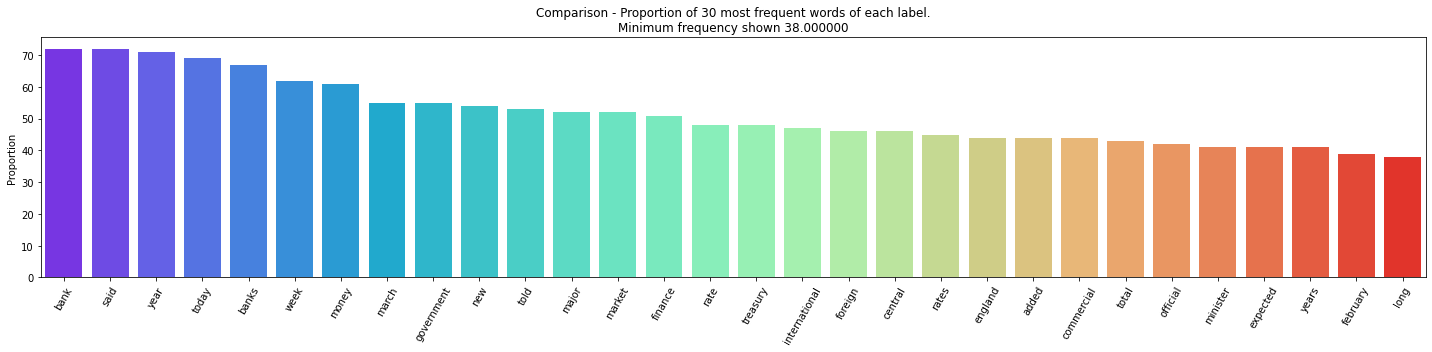

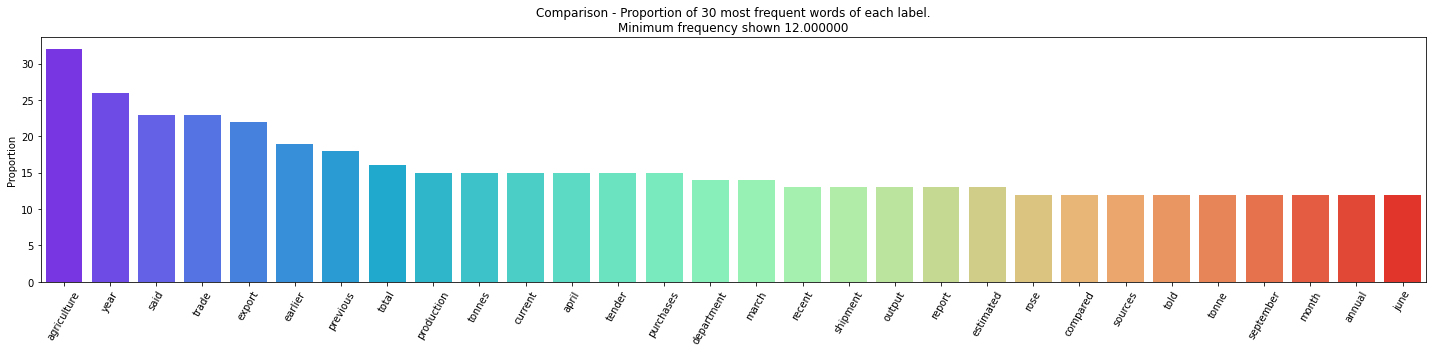

In [18]:
# get the k most frequent words
k = 30
import seaborn as sns
import matplotlib.pyplot as plt

index_label_0 = np.argwhere(np.array(y_train) == 0).reshape(-1)
x_train_0 = x_train_tf[index_label_0]

all_frequencies = dict()

for i in range(7):
    dico_frequencies = dict()
    idx = np.argwhere(np.array(clusters[1]) == i).reshape(-1)
    for sentence in x_train_0[idx]:
        for j in range(len(sentence)):
            if sentence[j] == 1:
                if j in dico_frequencies.keys():
                    dico_frequencies[j] += 1
                else:
                    dico_frequencies[j] = 1
    # print(dico_frequencies)
    # TODO sort dictionary correctly !
    all_frequencies[i] = dico_frequencies

def plot_word_frq_compare(df_count, filename, save=True):
    plt.figure(figsize=(20,5))
    sns.barplot(data=df_count,
                x="word",
                y="count",
                # hue="label",
                palette="rainbow")
    plt.title(f"Comparison - Proportion of {len(df_count)} most frequent words of each label.\n"
              f"Minimum frequency shown {df_count['count'].min():.6f}")
    plt.ylabel("Proportion")
    plt.xlabel("")
    plt.xticks(rotation=60)
    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()


for i in range(7):
    df = pd.DataFrame(columns=['index','count'], data=zip(list(all_frequencies[i].keys()), list(all_frequencies[i].values())))
    df.sort_values(by="count",ascending=False,ignore_index=True,inplace=True)
    df = df.head(k)
    df['word'] = vocabulary[df['index'].tolist()]
    plot_word_frq_compare(df, f"./most_{k}_used_words_cluster_{i}.jpg")
